In [1]:
import os
import cv2
import shutil
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras.preprocessing.image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Conv2D, MaxPool2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from sklearn.preprocessing import LabelEncoder

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

# Set the path to the dataset
dataset_path = "/content/drive/MyDrive/dataset/Train & Val"
os.listdir(dataset_path)

Mounted at /content/drive


['Grade 3', 'Grade 2', 'Grade 1', 'processed']

In [3]:
print('Grade 1 :',len(os.listdir("/content/drive/MyDrive/dataset/Train & Val/Grade 1")))
print('Grade 2 :',len(os.listdir("/content/drive/MyDrive/dataset/Train & Val/Grade 2")))
print('Grade 3 :',len(os.listdir("/content/drive/MyDrive/dataset/Train & Val/Grade 3")))

Grade 1 : 1000
Grade 2 : 1000
Grade 3 : 1000


In [4]:
import cv2
import numpy as np
import os

# Load the dataset
data = []
labels = []

# Iterate through the dataset path and load the images
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)

        # Check if the image file exists
        if os.path.isfile(image_path):
            # Read the image file
            image = cv2.imread(image_path)

            # Check if the image reading was successful
            if image is not None:
                # Convert the image to rgb
                rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                # Resize the rgb image
                resized_image = cv2.resize(rgb_image, (150, 150))

                data.append(resized_image)
                labels.append(category)

# Convert data and labels to numpy arrays
data = np.array(data)
labels = np.array(labels)

In [5]:
# Perform label encoding
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

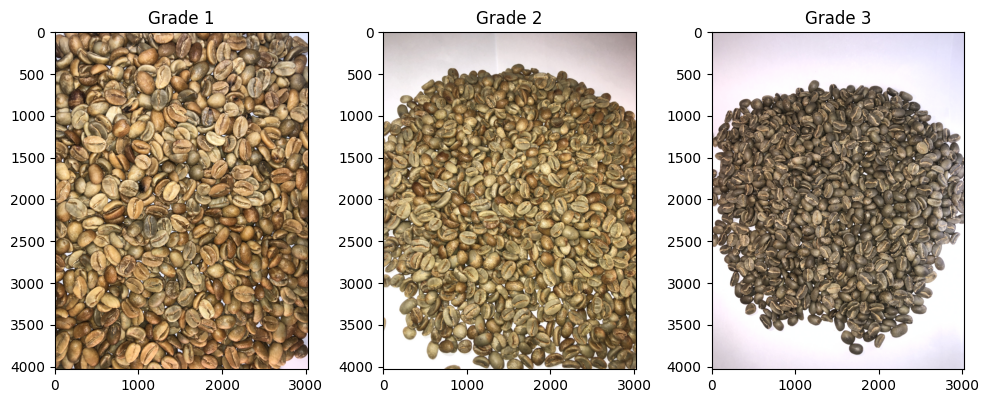

In [6]:
# Get a list of images in each grade folder
grade1_images = os.listdir(os.path.join(dataset_path, "Grade 1"))
grade2_images = os.listdir(os.path.join(dataset_path, "Grade 2"))
grade3_images = os.listdir(os.path.join(dataset_path, "Grade 3"))

# Choose a random sample from each grade
sample_grade1 = random.choice(grade1_images)
sample_grade2 = random.choice(grade2_images)
sample_grade3 = random.choice(grade3_images)

# Load and display the sample images
sample1_path = os.path.join(dataset_path, "Grade 1", sample_grade1)
sample2_path = os.path.join(dataset_path, "Grade 2", sample_grade2)
sample3_path = os.path.join(dataset_path, "Grade 3", sample_grade3)

sample1_img = cv2.imread(sample1_path)
sample2_img = cv2.imread(sample2_path)
sample3_img = cv2.imread(sample3_path)

# Convert BGR to RGB
sample1_img = cv2.cvtColor(sample1_img, cv2.COLOR_BGR2RGB)
sample2_img = cv2.cvtColor(sample2_img, cv2.COLOR_BGR2RGB)
sample3_img = cv2.cvtColor(sample3_img, cv2.COLOR_BGR2RGB)

# Plot the images
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(sample1_img)
plt.title("Grade 1")

plt.subplot(1, 3, 2)
plt.imshow(sample2_img)
plt.title("Grade 2")

plt.subplot(1, 3, 3)
plt.imshow(sample3_img)
plt.title("Grade 3")

plt.tight_layout()
plt.show()

In [7]:
# Perform data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Random rotation
    width_shift_range=0.1,  # Random horizontal shift
    height_shift_range=0.1,  # Random vertical shift
    shear_range=0.1,  # Shear transformation
    zoom_range=0.1,  # Random zoom
    horizontal_flip=True,  # Random horizontal flip
)
val_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# Split the dataset into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42, shuffle=True
)

In [9]:
# Apply data augmentation to the training set
train_generator = train_datagen.flow(train_data, train_labels, batch_size=32)

# Apply data augmentation to the validation set
val_generator = val_datagen .flow(val_data, val_labels, batch_size=32)

In [10]:
# Get the class names
class_names = label_encoder.classes_

# Display the class names
print("Class Names:", class_names)

Class Names: ['Grade 1' 'Grade 2' 'Grade 3']


In [11]:
# Normalize the image data
train_data = train_data.astype('float32') / 255.0
val_data = val_data.astype('float32') / 255.0

# Print the shape of each dataset
print("Train data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)

Train data shape: (2400, 150, 150, 3)
Validation data shape: (600, 150, 150, 3)
Train labels shape: (2400,)
Validation labels shape: (600,)


In [12]:
print('Train :', len(train_data))
print('Validation :', len(val_data))

Train : 2400
Validation : 600


**MOBILENET**

In [13]:
from tensorflow.keras.applications import MobileNetV2

# Load the MobileNetV2 model without the top classifier
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model layers
base_model.trainable = False

# Create a new model on top of the base model
mobilenetv2_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model
mobilenetv2_model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 [==============================] - 1s 0us/step


In [14]:
mobilenetv2_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 2,422,339
Trainable params: 164,355
Non-tr

In [15]:
# Train the model
history_v2 = mobilenetv2_model.fit(train_data, train_labels,
                    epochs=15,
                    batch_size=32,
                    validation_data=(val_data, val_labels))

Epoch 1/15
75/75 [==============================] - 74s 898ms/step - loss: 0.8294 - accuracy: 0.6458 - val_loss: 0.3563 - val_accuracy: 0.9583
Epoch 2/15
75/75 [==============================] - 65s 878ms/step - loss: 0.2815 - accuracy: 0.9400 - val_loss: 0.1559 - val_accuracy: 0.9867
Epoch 3/15
75/75 [==============================] - 56s 751ms/step - loss: 0.1429 - accuracy: 0.9783 - val_loss: 0.0915 - val_accuracy: 0.9950
Epoch 4/15
75/75 [==============================] - 60s 794ms/step - loss: 0.0906 - accuracy: 0.9900 - val_loss: 0.0603 - val_accuracy: 0.9967
Epoch 5/15
75/75 [==============================] - 66s 882ms/step - loss: 0.0652 - accuracy: 0.9929 - val_loss: 0.0472 - val_accuracy: 0.9950
Epoch 6/15
75/75 [==============================] - 68s 908ms/step - loss: 0.0500 - accuracy: 0.9937 - val_loss: 0.0350 - val_accuracy: 0.9967
Epoch 7/15
75/75 [==============================] - 67s 901ms/step - loss: 0.0388 - accuracy: 0.9954 - val_loss: 0.0284 - val_accuracy: 0.9967

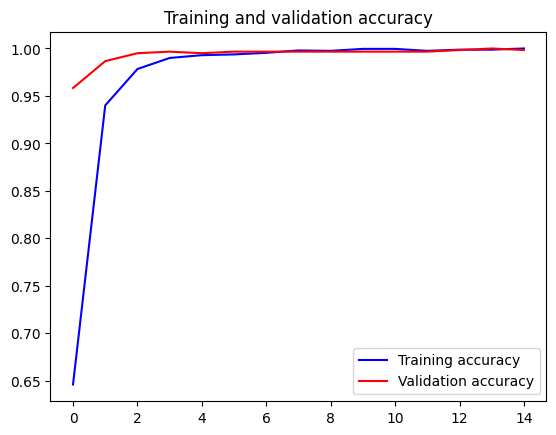

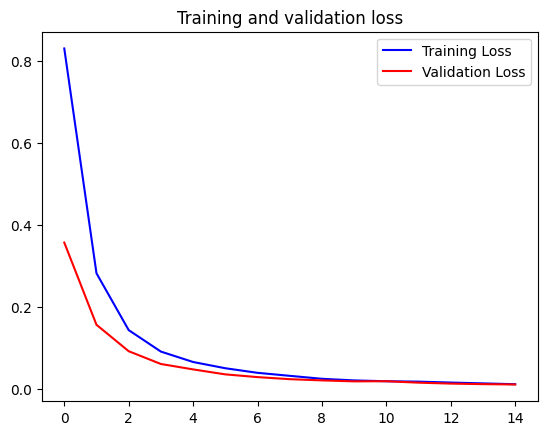

In [16]:
import matplotlib.pyplot as plt

acc = history_v2.history['accuracy']
val_acc = history_v2.history['val_accuracy']
loss = history_v2.history['loss']
val_loss = history_v2.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [17]:
# Get the train accuracy
train_loss, train_accuracy = mobilenetv2_model.evaluate(train_data, train_labels)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)

# Get the val accuracy
val_loss, val_accuracy = mobilenetv2_model.evaluate(val_data, val_labels)
print("Val Loss:", val_loss)
print("Val Accuracy:", val_accuracy)

75/75 [==============================] - 52s 673ms/step - loss: 0.0065 - accuracy: 1.0000
Train Loss: 0.006536754779517651
Train Accuracy: 1.0
19/19 [==============================] - 12s 632ms/step - loss: 0.0104 - accuracy: 0.9983
Val Loss: 0.010390751995146275
Val Accuracy: 0.9983333349227905


In [18]:
mobilenetv2_model.save('mobilenetv2_model.h5')
mobilenetv2_model.save('mobilenetv2_model')
!zip -r 'mobilenetv2_model.zip' 'mobilenetv2_model'

  adding: mobilenetv2_model/ (stored 0%)
  adding: mobilenetv2_model/assets/ (stored 0%)
  adding: mobilenetv2_model/saved_model.pb (deflated 91%)
  adding: mobilenetv2_model/fingerprint.pb (stored 0%)
  adding: mobilenetv2_model/keras_metadata.pb (deflated 96%)
  adding: mobilenetv2_model/variables/ (stored 0%)
  adding: mobilenetv2_model/variables/variables.index (deflated 76%)
  adding: mobilenetv2_model/variables/variables.data-00000-of-00001 (deflated 8%)


In [19]:
import pathlib

converter = tf.lite.TFLiteConverter.from_saved_model('mobilenetv2_model')

# Set the optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

tflite_model = converter.convert()

tflite_model_file = pathlib.Path('./mobilenetv2_model.tflite')
tflite_model_file.write_bytes(tflite_model)

2674736

In [20]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Set the path to the test dataset folder
test_dataset_path = "/content/drive/MyDrive/dataset/Test"

# Load the test dataset
test_data = []
test_labels = []

# Iterate through the test dataset path and load the images
for category in os.listdir(test_dataset_path):
    category_path = os.path.join(test_dataset_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (150, 150))
        test_data.append(image)
        test_labels.append(category)

# Convert test_data and test_labels to numpy arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Create a label encoder and fit it on test_labels
label_encoder = LabelEncoder()
test_labels = label_encoder.fit_transform(test_labels)

# Apply data normalization to test_data
test_data = test_data.astype('float32') / 255.0

# Create a dictionary to store the accuracy for each folder
folder_accuracy = {}

# Iterate over the folders in the test dataset
for folder in os.listdir(test_dataset_path):
    folder_path = os.path.join(test_dataset_path, folder)

    # Filter the test data and labels for the current folder
    folder_test_data = test_data[test_labels == label_encoder.transform([folder])[0]]
    folder_test_labels = test_labels[test_labels == label_encoder.transform([folder])[0]]

    # Evaluate the model on the current folder's test data
    _, accuracy = mobilenetv2_model.evaluate(folder_test_data, folder_test_labels, verbose=0)
    folder_accuracy[folder] = accuracy

# Print the accuracy for each folder
for folder, accuracy in folder_accuracy.items():
    print(f"Accuracy for folder {folder}: {accuracy}")


Accuracy for folder Grade 3: 0.9800000190734863
Accuracy for folder Grade 2: 0.9399999976158142
Accuracy for folder Grade 1: 0.9399999976158142


In [21]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = mobilenetv2_model.evaluate(test_data, test_labels, verbose=0)

# Print the test accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Test Loss: 0.10352127254009247
Test Accuracy: 0.95333331823349


In [22]:
# Make predictions on the test data
test_predictions = mobilenetv2_model.predict(test_data)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

# Decode the predicted labels using the label encoder
predicted_classes = label_encoder.inverse_transform(predicted_labels)

# Compare the predicted classes with the true classes
for i in range(len(test_labels)):
    print("True Label: ", label_encoder.inverse_transform([test_labels[i]]))
    print("Predicted Label: ", predicted_classes[i])
    print("------------------------------------")

10/10 [==============================] - 6s 472ms/step
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
------------------------------------
True Label:  ['Grade 3']
Predicted Label:  Grade 3
--------------

10/10 [==============================] - 7s 718ms/step


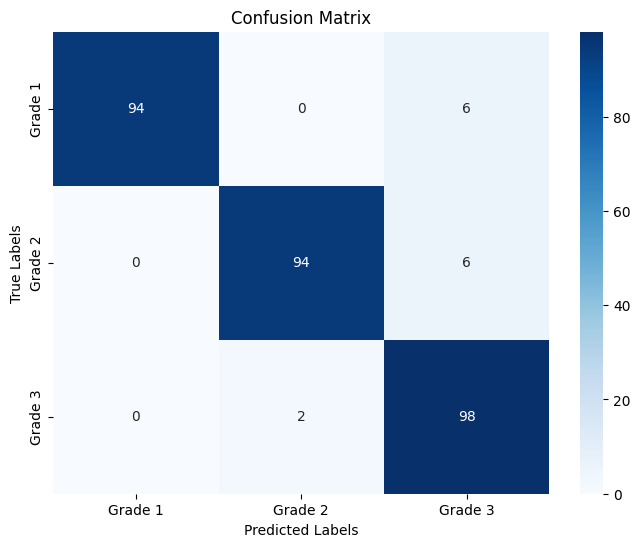

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Generate predictions on the test set
test_predictions = mobilenetv2_model.predict(test_data)

# Convert the predicted probabilities to class labels
test_predicted_labels = np.argmax(test_predictions, axis=1)

# Create a confusion matrix
cm = confusion_matrix(test_labels, test_predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

10/10 [==============================] - 5s 499ms/step


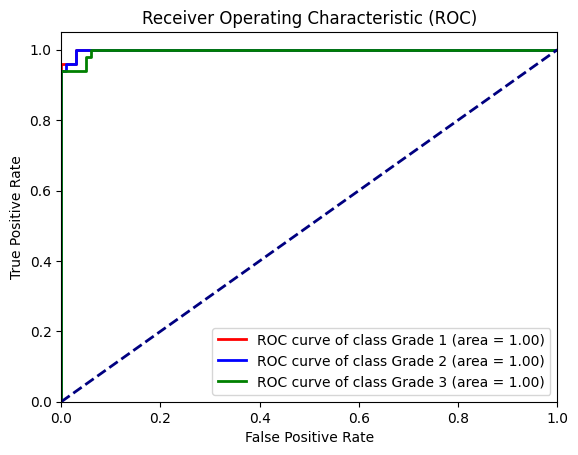

Macro-average ROC AUC: 0.9980666666666665


In [24]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Convert labels to binary format
binary_labels = label_binarize(test_labels, classes=np.arange(len(class_names)))

# Compute the predicted probabilities for each class
class_probabilities = mobilenetv2_model.predict(test_data)

# Compute the macro-average ROC AUC score
roc_auc = roc_auc_score(binary_labels, class_probabilities, average='macro')

# Plot the ROC curve for each class
plt.figure()
lw = 2
colors = ['red', 'blue', 'green']  # Add more colors if there are more classes
for i, color in zip(range(len(class_names)), colors):
    fpr, tpr, _ = roc_curve(binary_labels[:, i], class_probabilities[:, i])
    roc_auc_class = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc_class))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print the macro-average ROC AUC score
print("Macro-average ROC AUC:", roc_auc)

In [25]:
from sklearn.metrics import classification_report

# Make predictions on the test data
test_predictions = mobilenetv2_model.predict(test_data)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(test_predictions, axis=1)

# Decode the predicted labels using the label encoder
predicted_classes = label_encoder.inverse_transform(predicted_labels)

# Generate the classification report
report = classification_report(test_labels, predicted_labels, target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)

10/10 [==============================] - 7s 722ms/step
Classification Report:
              precision    recall  f1-score   support

     Grade 1       1.00      0.94      0.97       100
     Grade 2       0.98      0.94      0.96       100
     Grade 3       0.89      0.98      0.93       100

    accuracy                           0.95       300
   macro avg       0.96      0.95      0.95       300
weighted avg       0.96      0.95      0.95       300

